<a href="https://colab.research.google.com/github/BondaiKa/lane_line_recognition/blob/feature%2Ftu-simple-using/notebooks/TuSimple_standardize_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import glob
import json
import math
import cv2
import h5py
import logging
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf

from abc import ABCMeta, abstractmethod
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Model
from typing import Tuple, List, Dict, Iterable, Optional, NamedTuple, Union, Tuple, List, Callable, Type
from pathlib import Path
from google.colab.patches import cv2_imshow

%matplotlib inline

In [ ]:
log = logging.getLogger(__name__)

In [ ]:
!ls drive/MyDrive/Ilmenau/tusimple/

label_data_joined.json	test_set.zip			  train_set.zip
test_label.json		train_label_data_joined_old.json


In [ ]:
%%capture
!unzip "/content/drive/My Drive/Ilmenau/tusimple/train_set.zip" -d "/tmp/"

In [ ]:
%%capture
!unzip "/content/drive/My Drive/Ilmenau/tusimple/test_set.zip" -d "/tmp/"

In [ ]:
INPUT_SHAPE = (256, 256, 1)
FINAL_WIDTH=INPUT_SHAPE[0]
FINAL_HEIGHT=INPUT_SHAPE[1]
FINAL_SHAPE = (INPUT_SHAPE[0],INPUT_SHAPE[1])
BATCH_SIZE = 16
AMOUNT_OF_FRAMES = 10000
VALIDATION_SPLIT = 0.1
MAX_LINES_PER_FRAME = 5
MAX_NUM_POINTS =  91
NUM_TYPE_OF_LINES = 5

# Multiply polygonal chains with coefficient below to compare 
# with neural net output, then you should divide to this number
RESCALE_POLYLINE_COEFFICIENT = 0.003

MODEL_NAME = f'tu-simple-polyline-{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}-shape'

In [ ]:
!ls /tmp/clips

0313-1	0313-2	0530  0531  0601


In [ ]:
# BASE_DIR = "/tmp/dataset/VIL100/"
# IMAGE_PATH = BASE_DIR + "JPEGImages/"
# JSON_PATH = BASE_DIR + "Json/"
# JSON_HDF5_DATASET_PATH = BASE_DIR + "hdf5/"

TU_SIMPLE_FRAME_DATASET_PATH="/tmp"
TU_SIMPLE_JSON_HDF5_DATASET_PATH="/tmp/hdf5"
TU_SIMPLE_JSON_PATH="/content/drive/My Drive/Ilmenau/tusimple/label_data_joined.json"

frame_glob_path = TU_SIMPLE_FRAME_DATASET_PATH + '/clips/*/*/*20.jpg'
json_hdf5_glob_path = TU_SIMPLE_JSON_HDF5_DATASET_PATH + '/clips/*/*/*20.jpg.hdf5'

print(TU_SIMPLE_FRAME_DATASET_PATH)
print(TU_SIMPLE_JSON_HDF5_DATASET_PATH)
print(TU_SIMPLE_JSON_PATH)

/tmp
/tmp/hdf5
/content/drive/My Drive/Ilmenau/tusimple/label_data_joined.json


In [ ]:
frame_glob_path = TU_SIMPLE_FRAME_DATASET_PATH + '/clips/*/*/*20.jpg'
json_hdf5_glob_path = TU_SIMPLE_JSON_HDF5_DATASET_PATH + '/clips/*/*/*20.jpg.hdf5'

In [ ]:
print(frame_glob_path)
print(json_hdf5_glob_path)

/tmp/clips/*/*/*20.jpg
/tmp/hdf5/clips/*/*/*20.jpg.hdf5


In [ ]:
class Color(NamedTuple):
    red = (255, 0, 0)
    green = (0, 255, 0)
    blue = (0, 0, 255)
    purple = (255, 0, 255)
    yellow = (255, 255, 0)

    sequence = [red, green, blue, purple, yellow]

class TuSimpleJson:
    frame_path = 'raw_file'
    lane_widths = 'lanes'
    lane_heights = 'h_samples'


class TuSimpleHdf5:
    group_name = 'polylines'
    dataset_polylines_width = 'polylines_width'
    dataset_polylines_height = 'polylines_height'


def concat_polyline(polyline_width: np.ndarray, polyline_height: np.ndarray) -> np.ndarray:
    return np.concatenate((polyline_width.reshape(-1, 1), polyline_height.reshape(-1, 1)), axis=1)


def test_tu_simple_generator(generator: Sequence, draw_line=False) -> None:
    """Test tu simple generator"""
    original_frames, original_polylines = generator[0]
    original_frame = original_frames[0]
    polyline_widths, polyline_height = original_polylines[0][0], original_polylines[1][0]

    polyline_width_list = np.split(polyline_widths, 5)

    if draw_line:
        for polyline_width, color in zip(polyline_width_list, Color.sequence[:len(polyline_width_list)]):
            polyline = concat_polyline(polyline_width, polyline_height)
            polyline /= 0.003
            original_frame = cv2.polylines(original_frame, np.int32(polyline).reshape((-1, 1, 2)), 1,
                                           color=color,
                                           thickness=5)

    cv2.imshow(f'frame_with_polyline_{original_frame.shape}', original_frame)
    cv2.waitKey(0)


In [ ]:
from abc import ABCMeta, abstractmethod


class AbstractConverter(metaclass=ABCMeta):
    @abstractmethod
    def get_data_from_file(self, json_path: str):
        raise NotImplementedError

    @abstractmethod
    def exec(self):
        raise NotImplementedError


In [ ]:
class TuSimpleJsonConverter(AbstractConverter):
    def __init__(self,
                 max_lines_per_frame: int,
                 max_num_points: int,
                 json_file_path: str,
                 final_shape_to_convert: Tuple[int, int],
                 frame_dataset_path: str,
                 rescale_polyline_coef: float,
                 final_binary_json_path: str,
                 ):
        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.json_file = json_file_path
        self.frame_dataset_path = frame_dataset_path
        self.final_shape_to_convert = final_shape_to_convert
        self.rescale_polyline_coef = rescale_polyline_coef
        self.TU_SIMPLE_EXPECTED_SHAPE = (1280, 720)
        self.final_binary_json_path = final_binary_json_path

    def _verify_frame_shape(self, frame_path: np.ndarray) -> Tuple[int, int]:
        """Check that each frame has same expected shape"""
        frame = cv2.imread(frame_path)
        height, width = frame.shape[0], frame.shape[1]
        if self.TU_SIMPLE_EXPECTED_SHAPE[0] != width or \
                self.TU_SIMPLE_EXPECTED_SHAPE[1] != height:
            log.warning('Shape of frame and expected is not equal! '
                        f'Real shape:{width}x{height}')
            raise ValueError('Shape of frame and expected is not equal! '
                             f'Real shape:{width}x{height}')
        return width, height

    def __scale_widths(self, original_width: int, polyline_widths: np.ndarray):
        """Scale widths data"""
        polyline_widths = np.where(
            polyline_widths > 0,
            polyline_widths / original_width,
            polyline_widths
        )
        polyline_widths = np.where(polyline_widths == -2, -1, polyline_widths)
        polyline_widths = np.apply_along_axis(
            func1d=np.pad,
            axis=1,
            arr=polyline_widths,
            pad_width=(self.max_num_points - polyline_widths.shape[1], 0),
            mode='constant',
            constant_values=(-1,)
        )
        empty_polylines = np.full(shape=((self.max_lines_per_frame - polyline_widths.shape[0]) * self.max_num_points),
                                  fill_value=-1)
        return np.hstack([polyline_widths.flatten(), empty_polylines])

    def __scale_heights(self, original_height: int, polyline_heights: np.ndarray):
        """Scale heights data"""
        polyline_heights = np.where(
            polyline_heights > 0,
            polyline_heights / original_height,
            polyline_heights
        )
        polyline_heights = np.pad(polyline_heights, pad_width=(self.max_num_points - polyline_heights.shape[0], 0),
                                  mode='constant',
                                  constant_values=(-1,))
        return np.tile(polyline_heights, self.max_lines_per_frame)

    def scale_polylines(self, original_width: int, original_height: int,
                        polyline_widths: np.ndarray, polyline_heights: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Scale polygonal chains: divide and standardize dataset for NN input
        :param original_width: initial frame width
        :param original_height:initial frame height
        :param polyline_widths: polygonal widths
        :param polyline_heights: polygonal heights
        :return: scaled and prepared polygonal widths and heights
        """
        # TODO @Karim: check adding -1 at the start of each array!!!
        polyline_widths = self.__scale_widths(original_width=original_width, polyline_widths=polyline_widths)
        polyline_heights = self.__scale_heights(original_height=original_height, polyline_heights=polyline_heights)
        return polyline_widths, polyline_heights

    def get_polylines_from_json_line(self, line: str) -> Tuple[str, np.ndarray, np.ndarray]:
        """Retrieve polygonal chains from json file"""
        json_line = json.loads(line)
        frame_path = json_line.pop(TuSimpleJson.frame_path)
        frame_full_path = self.frame_dataset_path + '/' + frame_path
        width, height = self._verify_frame_shape(frame_full_path)
        lane_widths, lane_heights = self.scale_polylines(
            original_width=width,
            original_height=height,
            polyline_widths=np.array(json_line[TuSimpleJson.lane_widths]),
            polyline_heights=np.array(json_line[TuSimpleJson.lane_heights])
        )
        return frame_path, lane_widths, lane_heights

    def get_data_from_file(self, json_path: str):
        """Read json line by line"""
        # TODO @Karim: investigate and decide to add labels
        with open(json_path, 'r') as f:
            for json_frame_data_line in f.readlines():
                yield self.get_polylines_from_json_line(json_frame_data_line)

    def exec(self):
        for frame_path, polylines_width, polylines_height in self.get_data_from_file(self.json_file):
            full_path = self.final_binary_json_path + '/' + '/'.join(frame_path.split('/')[:-1])
            Path(full_path).mkdir(parents=True, exist_ok=True)

            with h5py.File(f"{self.final_binary_json_path}/{frame_path}.hdf5", "w") as f:
                grp = f.create_group(TuSimpleHdf5.group_name)
                grp.create_dataset(TuSimpleHdf5.dataset_polylines_width, data=polylines_width, dtype='float32')
                grp.create_dataset(TuSimpleHdf5.dataset_polylines_height, data=polylines_height, dtype='float32')



In [ ]:
TU_SIMPLE_JSON_PATH

'/content/drive/My Drive/Ilmenau/tusimple/label_data_joined.json'

In [ ]:
TU_SIMPLE_FRAME_DATASET_PATH

'/tmp'

In [ ]:
tu_simple_converter = TuSimpleJsonConverter(
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
    json_file_path=TU_SIMPLE_JSON_PATH,
    final_shape_to_convert=(FINAL_WIDTH, FINAL_HEIGHT),
    frame_dataset_path=TU_SIMPLE_FRAME_DATASET_PATH,
    final_binary_json_path=TU_SIMPLE_JSON_HDF5_DATASET_PATH,
    rescale_polyline_coef=RESCALE_POLYLINE_COEFFICIENT,
)

In [ ]:
tu_simple_converter.exec()

In [ ]:
class AbstractFrameGenerator(metaclass=ABCMeta):
    @abstractmethod
    def get_data_from_file(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def get_frame_from_file(self, frame_path: str):
        raise NotImplementedError


class AbstractFrameGeneratorCreator(metaclass=ABCMeta):
    TRAINING = 'training'
    VALIDATION = 'validation'

    __reverse_dataset_type = {
        TRAINING: VALIDATION,
        VALIDATION: TRAINING
    }
    __dataset = {}

    def __init__(self,
                 validation_split: float,
                 frame_glob_path: str,
                 json_hdf5_glob_path: str):
        """
        :param validation_split: split for train/validation sets
        :param frame_glob_path: glob pattern of frames
        :param json_hdf5_glob_path: glob pattern path of jsons
        """
        self.validation_split = validation_split
        self.__frame_glob_path = frame_glob_path
        self.__json_hdf5_glob_path = json_hdf5_glob_path

    def preprocess_files(self, subset: str, number_files: int) -> Tuple[List[str], List[str]]:
        """
        Sort and validate files for further loading and sending to NN

        :param subset: 'training' or 'validation'
        :param number_files: restrict max number of files from dataset
        :return: list of sorted and sliced files and json files
        """

        files = sorted(glob.glob(self.__frame_glob_path))
        log.info(f"Number of files in dataset: {len(files)}. Using in training/validation: {number_files}")
        files = files[:number_files]

        json_files = sorted(glob.glob(self.__json_hdf5_glob_path))[:number_files]
        files_count = len(files)
        json_files_count = len(json_files)

        print(f'Number of frames:{files_count}.\t'
              f'Number of json files:{json_files_count}')

        if files_count != json_files_count:
            log.error(f"Dataset files error"
                      f"Number of frames: ({files_count}). "
                      f"Number of jsons({json_files_count}")
            raise FileNotFoundError(
                f"Numbers of frames and jsons are not equal!")

        if not self.__reverse_dataset_type.get(subset):
            log.error(f'Wrong subset value: "{subset}"')
            raise ValueError(f'Wrong type of subset - {subset}. '
                             f'Available types: {self.__reverse_dataset_type.keys()}')

        if self.validation_split and 0.0 < self.validation_split < 1.0:
            split = int(files_count * (1 - self.validation_split))
            if subset == self.TRAINING:
                files = files[:split]
                json_files = json_files[:split]
            else:
                files = files[split:]
                json_files = json_files[split:]

        return files, json_files

    @abstractmethod
    def get_generator(self) -> Type:
        raise NotImplementedError

    def flow_from_directory(self,
                            subset: str,
                            number_files: int,
                            *args, **kwargs) -> Callable:
        files, json_files = self.preprocess_files(subset=subset,
                                                  number_files=number_files)
        return self.get_generator()(files=files,
                                    json_files=json_files,
                                    *args, **kwargs)


In [ ]:
Frame_ouput_type = np.ndarray
Polylines_width_ouput_type = Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,]
Polylines_height_ouput_type = Tuple[np.ndarray]

class TuSimpleFrameGenerator(AbstractFrameGenerator, Sequence):
    def __init__(self,
                 max_lines_per_frame: int,
                 max_num_points: int,
                 batch_size: int,
                 output_shape: Tuple[int, int],
                 shuffle: bool,
                 files: List[str],
                 json_files: List[str],
                 rescale=1 / 255.,
                 color_mode: str = 'grayscale',
                 ):
        self.batch_size = batch_size
        self.output_shape = output_shape
        self.rescale = rescale
        self.color_mode = color_mode
        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points

        if shuffle:
            temp = list(zip(files, json_files))
            random.shuffle(temp)
            self.files, self.json_files = zip(*temp)

        self.files_count = len(self.files)

    def get_data_from_file(self, json_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get from hdf5 all polylines
        :param json_path: path of json file
        :return: polylines
        """
        file = h5py.File(json_path, 'r')
        group = file.get(TuSimpleHdf5.group_name)
        return group.get(TuSimpleHdf5.dataset_polylines_width), group.get(TuSimpleHdf5.dataset_polylines_height)

    def get_frame_from_file(self, frame_path: str):
        frame = tf.keras.utils.load_img(frame_path,
                                        color_mode=self.color_mode,
                                        target_size=(self.output_shape[1], self.output_shape[0])
                                        )
        frame = tf.keras.preprocessing.image.img_to_array(frame)
        frame = frame * self.rescale
        frame = np.expand_dims(frame, 0)
        return frame

    def __len__(self):
        return math.ceil(self.files_count / self.batch_size)

    def __getitem__(self, idx: int) -> Tuple[Frame_ouput_type,
                                             Polylines_width_ouput_type,
                                             Polylines_height_ouput_type]:

        batch_frames_path = self.files[idx * self.batch_size:
                                       (idx + 1) * self.batch_size]
        batch_json_path = self.json_files[idx * self.batch_size:
                                          (idx + 1) * self.batch_size]

        polylines_width_output = np.empty(
            shape=(0, self.max_num_points * self.max_lines_per_frame))
        polylines_height_output = np.empty(
            shape=(0, self.max_num_points * self.max_lines_per_frame))

        frame_output = np.empty(shape=(0, self.output_shape[0], self.output_shape[1],1))

        for _frame, _json in zip(batch_frames_path, batch_json_path):
            polylines_width, polylines_height = self.get_data_from_file(_json)

            polylines_width_output = np.vstack([polylines_width_output, polylines_width])
            polylines_height_output = np.vstack([polylines_height_output, polylines_height])

            frame = self.get_frame_from_file(_frame)
            frame_output = np.vstack((frame_output, frame))

        return frame_output, (polylines_width_output, polylines_height_output)


class TuSimpleFrameGeneratorCreator(AbstractFrameGeneratorCreator):
    def get_generator(self) -> Type[TuSimpleFrameGenerator]:
        return TuSimpleFrameGenerator


In [ ]:
print(frame_glob_path)
print(json_hdf5_glob_path)

/tmp/clips/*/*/*20.jpg
/tmp/hdf5/clips/*/*/*20.jpg.hdf5


In [ ]:
data_gen = TuSimpleFrameGeneratorCreator(
    validation_split=0.1,
    frame_glob_path=frame_glob_path,
    json_hdf5_glob_path=json_hdf5_glob_path,
)

train_generator = data_gen.flow_from_directory(
    subset='training', shuffle=True, batch_size=BATCH_SIZE,
    number_files=AMOUNT_OF_FRAMES,
    output_shape=FINAL_SHAPE,
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
)

validation_generator = data_gen.flow_from_directory(
    subset='validation', shuffle=True, batch_size=BATCH_SIZE,
    number_files=AMOUNT_OF_FRAMES,
    output_shape=FINAL_SHAPE,
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
)

Number of frames:6408.	Number of json files:6408
Number of frames:6408.	Number of json files:6408


In [ ]:
def test_tu_simple_generator(generator: Sequence, draw_line=False) -> None:
    """Test tu simple generator"""
    original_frames, original_polylines = generator[0]
    original_frame = original_frames[0] * 255
    polyline_widths, polyline_height = original_polylines[0][0], original_polylines[1][0]

    polyline_width_list = np.split(polyline_widths, MAX_LINES_PER_FRAME)
    polyline_height_list = np.split(polyline_height, MAX_LINES_PER_FRAME)


    if draw_line:
        for polyline_width, polyline_height in zip(polyline_width_list, polyline_height_list):
            polyline_width *= INPUT_SHAPE[0]
            polyline_height *= INPUT_SHAPE[1]
            polyline = concat_polyline(polyline_width, polyline_height)
            original_frame = cv2.polylines(original_frame, np.int32(polyline).reshape((-1, 1, 2)), 1,
                                           color=(255,0,0),
                                           thickness=5)

    cv2_imshow(original_frame)
    cv2.waitKey(0)

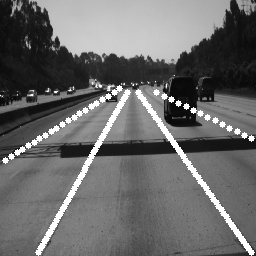

In [ ]:
# test_tu_simple_generator(train_generator, draw_line=True)

In [ ]:
def build_model(polyline_width_output_shape:int ,polyline_height_output_shape:int, input_shape:Tuple[int,int,int], model_name:str):

    input_img = layers.Input(shape=input_shape)

    # First block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(input_img)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Second block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Third block
    layer = layers.Conv2D(128, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Fourth block
    layer = layers.Conv2D(64, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)

    # GlobalMaxPool
    layer = layers.GlobalMaxPool2D()(layer)

    # polyline common part 
    polyline_common = tf.keras.layers.Dense(units=512, activation='relu')(layer)
    polyline_common = layers.BatchNormalization()(polyline_common)
    polyline_common = layers.Dropout(.2)(polyline_common) 

    # polyline height
    pol_1 = tf.keras.layers.Dense(units=256, activation='relu')(polyline_common)
    pol_1 = layers.BatchNormalization()(pol_1)
    pol_1 = layers.Dropout(.2)(pol_1)

    pol_1 = tf.keras.layers.Dense(units=128,activation='relu')(pol_1)
    pol_1 = layers.BatchNormalization()(pol_1)
    pol_1 = layers.Dropout(.2)(pol_1)

    # polyline width 
    pol_2 = tf.keras.layers.Dense(units=256, activation='relu')(polyline_common)
    pol_2 = layers.BatchNormalization()(pol_2)
    pol_2 = layers.Dropout(.2)(pol_2)

    pol_2 = tf.keras.layers.Dense(units=128,activation='relu')(pol_2)
    pol_2 = layers.BatchNormalization()(pol_2)
    pol_2 = layers.Dropout(.2)(pol_2)

    # output
    polyline_output_width = layers.Dense(polyline_width_output_shape,name='polyline_width')(pol_1)
    polyline_output_height = layers.Dense(polyline_height_output_shape,name='polyline_height')(pol_2)

    model = Model(input_img, outputs=[
        polyline_output_width,
        polyline_output_height,
      ], name = model_name
    )

    return model

In [ ]:
model_name = MODEL_NAME
logdir = f"logs/{model_name}"
checkpoint_filepath = f"/model/{model_name}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop_polyline_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_polyline_width_loss'
)

reduce_lr_callback_depends_on_polyline_1_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_width_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)
reduce_lr_callback_depends_on_polyline_2_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_height_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_polyline_width_loss',
    mode='max',
    save_best_only=True)

In [ ]:
class DrawPolylineOnEpochEnd(tf.keras.callbacks.Callback):
  """Draw polyline at the end on the epoch to test the net. It skip one batch on validation but похуй"""
  def __init__(self,train_generator, validation_generator,model,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.model = model

  def __filter_coordination_for_resolution(self, polyline: np.ndarray) -> np.ndarray:
    valid = ((polyline[:, 0] > 0) & (polyline[:, 1] > 0)
              & (polyline[:, 0] < INPUT_SHAPE[0]) & (polyline[:, 1] < INPUT_SHAPE[1]))
    return polyline[valid]

  def __filter_coordinates(self, list_of_polylines: List[np.ndarray]) -> np.ndarray:
    """Remove empty points and coordinates x or y, that is less than 0"""
    list_of_polylines = list(map(lambda x: x.reshape(-1, 2), list_of_polylines))
    return list(map(lambda polyline: self.__filter_coordination_for_resolution(polyline),
                    list_of_polylines))  

  def concat_polyline(self,polyline_width: np.ndarray, polyline_height: np.ndarray) -> np.ndarray: 
    return np.concatenate((polyline_width.reshape(-1, 1), polyline_height.reshape(-1, 1)), axis=1)

  def draw_polyline_in_frame(self, _frame:np.ndarray, polylines:Tuple[np.ndarray,np.ndarray],thickness:int)->np.ndarray:
    copy_frame = np.copy(_frame)
    polyline_widths, polyline_heights = polylines[0][0], polylines[1][0]
    polyline_width_list = np.split(polyline_widths, MAX_LINES_PER_FRAME)
    polyline_height_list = np.split(polyline_heights, MAX_LINES_PER_FRAME)

    for polyline_width, polyline_height in zip(polyline_width_list, polyline_height_list):
      polyline_width *= INPUT_SHAPE[0]
      polyline_height *= INPUT_SHAPE[1]
      polyline = self.concat_polyline(polyline_width, polyline_height)
      polyline = self.__filter_coordination_for_resolution(polyline)
      copy_frame = cv2.polylines(copy_frame, np.int32(polyline).reshape((-1, 1, 2)), 1,
                                      color=(255,0,0),
                                      thickness=thickness)
    return copy_frame

  def test_model(self, generator: Sequence):
    original_frames, original_polylines = generator[0]
    original_frame = original_frames[0]

    draw_original_polylines_frame = self.draw_polyline_in_frame(original_frame,original_polylines,thickness=2)

    original_frame = np.copy(original_frame)
    frame = np.expand_dims(original_frame, 0)
    res = self.model.predict(frame)

    final_frame = self.draw_polyline_in_frame(draw_original_polylines_frame,res,thickness=5)
    cv2_imshow(final_frame * 255)

  def on_epoch_end(self, epoch, logs=None):
      print(f'Epoch {epoch}. Draw polylines on train generator...')
      self.test_model(self.train_generator)



In [ ]:
model = build_model(
    polyline_width_output_shape = MAX_NUM_POINTS * MAX_LINES_PER_FRAME, 
    polyline_height_output_shape = MAX_NUM_POINTS * MAX_LINES_PER_FRAME, 
    input_shape = INPUT_SHAPE,
    model_name = MODEL_NAME,
)
# print(model.summary())

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
# tf.keras.utils.plot_model(model, "multi_output_model.png", show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01

model.compile(loss= {
      'polyline_width':tf.keras.losses.MeanAbsoluteError(),
      'polyline_height':tf.keras.losses.MeanAbsoluteError(),
    },
    optimizer=Adam(learning_rate=learning_rate),
    metrics={'polyline_width':tf.keras.metrics.MeanSquaredError(),
             'polyline_height':tf.keras.metrics.MeanSquaredError(),
             },)

Epoch 1/3
Epoch 0. Draw polylines on train generator...


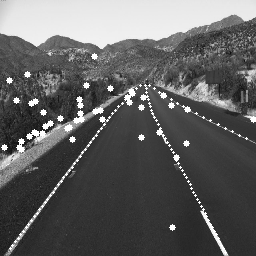

361/361 - 108s - loss: 0.3729 - polyline_width_loss: 0.2351 - polyline_height_loss: 0.1378 - polyline_width_mean_squared_error: 0.2213 - polyline_height_mean_squared_error: 0.0841 - val_loss: 0.7193 - val_polyline_width_loss: 0.6014 - val_polyline_height_loss: 0.1179 - val_polyline_width_mean_squared_error: 1.3267 - val_polyline_height_mean_squared_error: 0.0370 - lr: 0.0100 - 108s/epoch - 298ms/step
Epoch 2/3
Epoch 1. Draw polylines on train generator...


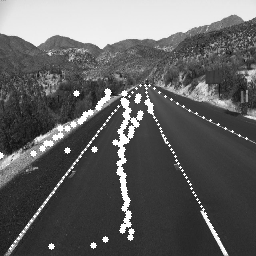

361/361 - 104s - loss: 0.1766 - polyline_width_loss: 0.1389 - polyline_height_loss: 0.0377 - polyline_width_mean_squared_error: 0.1357 - polyline_height_mean_squared_error: 0.0170 - val_loss: 0.3526 - val_polyline_width_loss: 0.2788 - val_polyline_height_loss: 0.0737 - val_polyline_width_mean_squared_error: 0.3529 - val_polyline_height_mean_squared_error: 0.0606 - lr: 0.0100 - 104s/epoch - 289ms/step
Epoch 3/3
Epoch 2. Draw polylines on train generator...


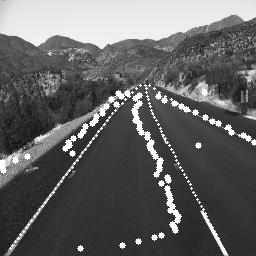

361/361 - 106s - loss: 0.1303 - polyline_width_loss: 0.1103 - polyline_height_loss: 0.0200 - polyline_width_mean_squared_error: 0.1093 - polyline_height_mean_squared_error: 0.0078 - val_loss: 0.5786 - val_polyline_width_loss: 0.5605 - val_polyline_height_loss: 0.0181 - val_polyline_width_mean_squared_error: 1.6981 - val_polyline_height_mean_squared_error: 0.0023 - lr: 0.0100 - 106s/epoch - 292ms/step


In [ ]:
history = model.fit(train_generator,
                    epochs=3,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model)
                      ],
                    )

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

Epoch 1/10
Epoch 0. Draw polylines on train generator...


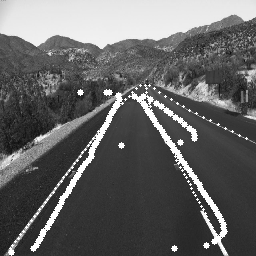

361/361 - 106s - loss: 0.1093 - polyline_width_loss: 0.0949 - polyline_height_loss: 0.0145 - polyline_width_mean_squared_error: 0.0970 - polyline_height_mean_squared_error: 0.0048 - val_loss: 0.2367 - val_polyline_width_loss: 0.2202 - val_polyline_height_loss: 0.0165 - val_polyline_width_mean_squared_error: 0.2807 - val_polyline_height_mean_squared_error: 0.0097 - lr: 0.0010 - 106s/epoch - 293ms/step
Epoch 2/10
Epoch 1. Draw polylines on train generator...


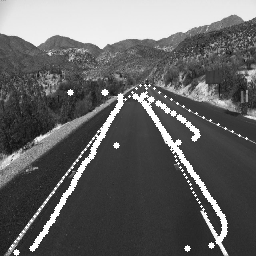

361/361 - 103s - loss: 0.1062 - polyline_width_loss: 0.0925 - polyline_height_loss: 0.0137 - polyline_width_mean_squared_error: 0.0950 - polyline_height_mean_squared_error: 0.0043 - val_loss: 0.2495 - val_polyline_width_loss: 0.2263 - val_polyline_height_loss: 0.0232 - val_polyline_width_mean_squared_error: 0.2915 - val_polyline_height_mean_squared_error: 0.0143 - lr: 0.0010 - 103s/epoch - 285ms/step
Epoch 3/10
Epoch 2. Draw polylines on train generator...


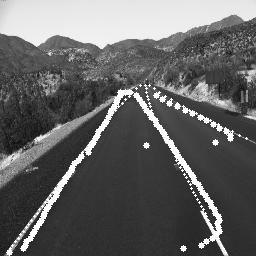

361/361 - 105s - loss: 0.1053 - polyline_width_loss: 0.0916 - polyline_height_loss: 0.0137 - polyline_width_mean_squared_error: 0.0947 - polyline_height_mean_squared_error: 0.0041 - val_loss: 1.4749 - val_polyline_width_loss: 1.3802 - val_polyline_height_loss: 0.0947 - val_polyline_width_mean_squared_error: 1481.1525 - val_polyline_height_mean_squared_error: 4.0138 - lr: 0.0010 - 105s/epoch - 289ms/step
Epoch 4/10


KeyboardInterrupt: ignored

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model)
                      ],
                    )

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
from google.colab import files

In [ ]:
model_name_download = MODEL_NAME + '.h5'
model_name_download

In [ ]:
model.save(model_name_download)

In [ ]:
files.download(model_name_download)